# Generating MNIST adversarial examples with AdvGAN

In [ ]:
!pip install tensorflow-io==0.25.0

!pip install git+https://github.com/tensorflow/docs
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
import os
import time

import matplotlib.pyplot as plt
import tensorflow as tf

from callbacks import ImageAdvGANCallback
from losses import carlini_wagner_loss_fn, l2_norm_soft_hinge_loss_fn
from models.advgan import AdvGAN
from models.components import get_discriminator, get_resnet_generator
from models.target import MNISTConvTarget

from util import (
    images_to_gif,
    generate_adv_examples,
    plot_image_results,
    plot_confusion_matrix
)

In [ ]:
IMAGES_DIR = 'images'
WEIGHTS_DIR = 'weights'

BASE_FILENAME = 'advgan_mnist'

In [ ]:
if not os.path.isdir(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)

if not os.path.isdir(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

In [ ]:
TARGET_LABEL = 3  # the chosen label for the targeted attack

BUFFER_SIZE = 60000
BATCH_SIZE = 128

INPUT_SHAPE = (28, 28, 1)
OUTPUT_CHANNELS = 1

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-af81c282-72ad-584d-20b9-5741139ae883)


## Data loading and preprocessing

Load the MNIST training set images:

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

print(f'training set: {train_images.shape}, {train_labels.shape}')
print(f'test set: {test_images.shape}, {test_labels.shape}')

training set: (60000, 28, 28), (60000,)
test set: (10000, 28, 28), (10000,)


Filter out the `TARGET_LABEL` samples, reshape the images to $28 \times 28 \times 1$ and normalize them to $[-1, 1]$:

In [ ]:
def filter(images, labels):
    target_filter = (labels != TARGET_LABEL)
    
    return images[target_filter], labels[target_filter]

In [ ]:
def reshape(images, labels):
    return images.reshape(images.shape[0], *INPUT_SHAPE).astype('float32'), labels

In [ ]:
def normalize(images, labels):
    return (images - 127.5) / 127.5, labels

In [ ]:
def preprocess(images, labels):
    return normalize(*reshape(*filter(images, labels)))

In [ ]:
train_images, train_labels = preprocess(train_images, train_labels)
test_images, test_labels = preprocess(test_images, test_labels)

Shuffle and batch the training set data:

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## AdvGAN

[AdvGAN](https://arxiv.org/pdf/1801.02610.pdf) is a generative adversarial network for creating adversarial examples that is based on image-to-image translation models such as [pix2pix](https://openaccess.thecvf.com/content_cvpr_2017/papers/Isola_Image-To-Image_Translation_With_CVPR_2017_paper.pdf) and [CycleGAN](https://openaccess.thecvf.com/content_ICCV_2017/papers/Zhu_Unpaired_Image-To-Image_Translation_ICCV_2017_paper.pdf).

It consists of three parts: the generator, the discriminator, and the target of the adversarial attacks.

The generator creates adversarial perturbations for the original images it receives as input, while the discriminator tries to distinguish between the original images and the adversarial images.

The target network is used for computing the adversarial loss, which guides the generator during training towards creating more successful adversarial images.

### Generator

The generator receives an image as input and shapes it into an adversarial perturbation of the desired size ($28 \times 28 \times 1$ for MNIST).

It is a modified ResNet of the following structure (taken from the [AdvGAN](https://openreview.net/pdf?id=HknbyQbC-) paper):

`c3s1-8, d16, d32, r32, r32, r32, r32, u16, u8, c3s1-3`,

where

* `c3s1-k` is a $3 \times 3$ Convolution-InstanceNorm-ReLU
layer with `k` filters and stride 1,
* `rk` is a residual block of two $3 \times 3$ convolutional layers
with the same numbers of filters,
* `dk` (downsampling layer) is a $3 \times 3$ Convolution-InstanceNorm-ReLU layer with
`k` filters and stride 2, and
* `uk` (upsampling layer) is a $3 \times 3$ FractionallyStridedConvolution-InstanceNorm-ReLU layer
with `k` filters, and stride 1/2.

Create a generator of the specified structure:

In [ ]:
generator = get_resnet_generator(
    INPUT_SHAPE,
    filters=8,
    kernel_size=(3, 3),
    num_downsampling_blocks=2,
    num_residual_blocks=4,
    num_upsampling_blocks=2,
    name='mnist_generator'
)

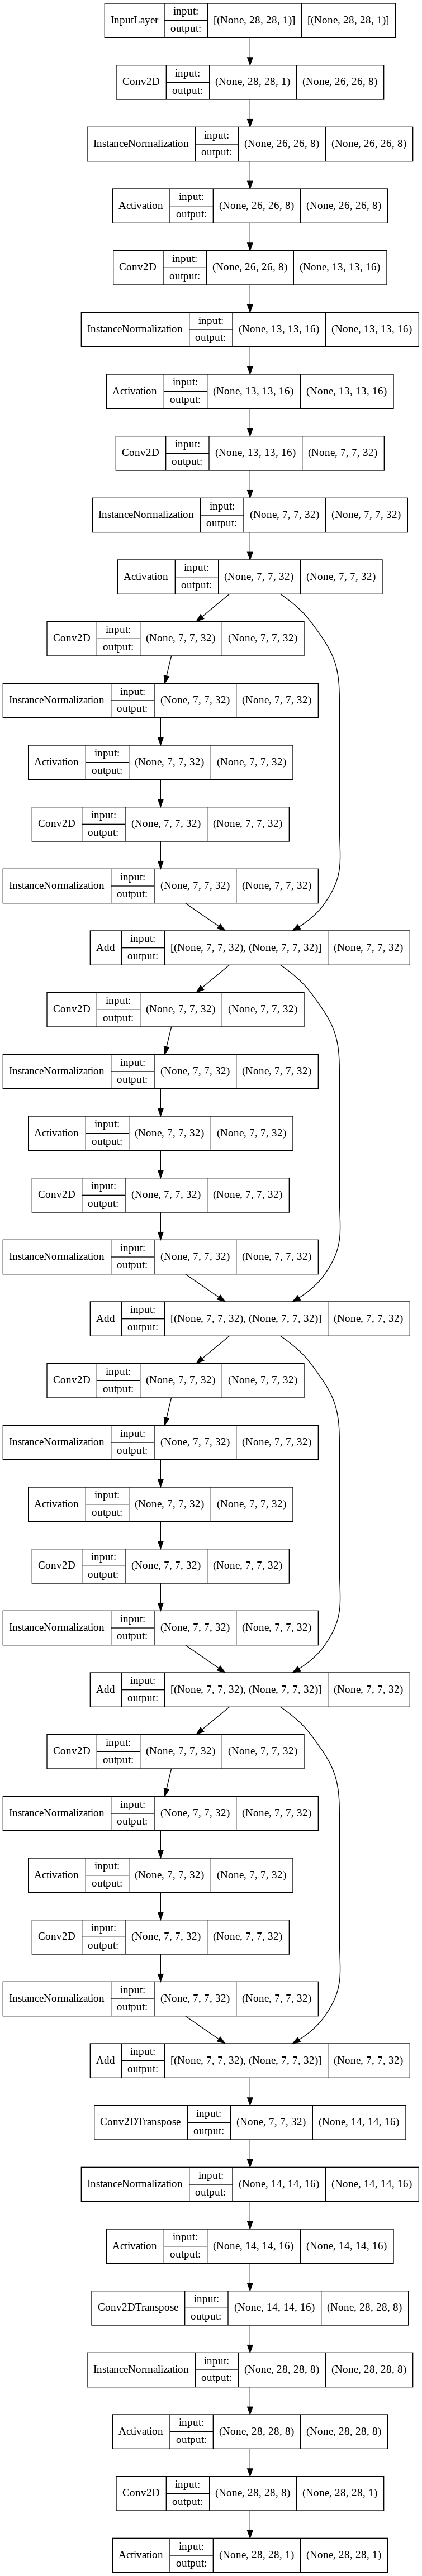

In [ ]:
generator.build((BATCH_SIZE, *INPUT_SHAPE))
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=False)

### Discriminator

The discriminator is a CNN-based binary classifier that tries to differentiate between real images (from the training set) and fake images (created by the generator).

Its structure is taken from the [AdvGAN](https://openreview.net/pdf?id=HknbyQbC-) paper:

`C8, C16, C32, FC`,

where `Ck` denotes a $4 \times 4$ Convolution-InstanceNorm-LeakyReLU layer with `k` filters and stride 2.
The output of the last convolutional layer is flattened, and a fully-connected (`FC`) layer is applied to produce a 1-dimensional output.
There is no InstanceNorm for the first layer.
The LeakyReLU slope is set to 0.2.

In [ ]:
discriminator = get_discriminator(
    INPUT_SHAPE,
    filters=8,
    num_downsampling_blocks=2,
    name='mnist_discriminator'
)

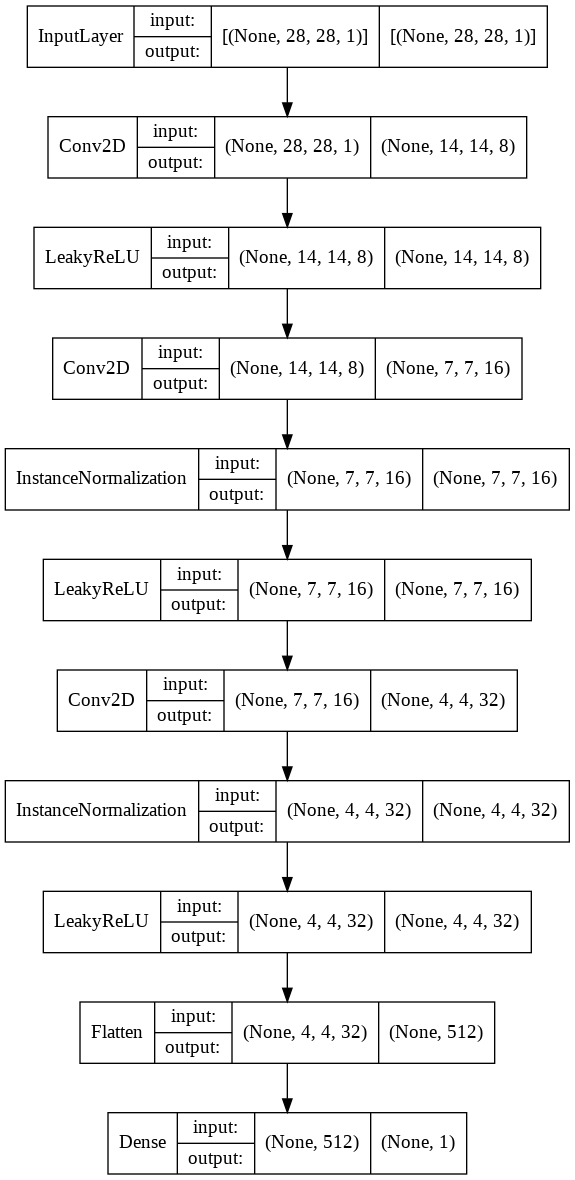

In [ ]:
discriminator.build((BATCH_SIZE, *INPUT_SHAPE))
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=False)

### Target

The pre-trained `MNISTConvTarget` model is the target of the attacks.
It is used for computing the adversarial loss, which guides the generator during training.

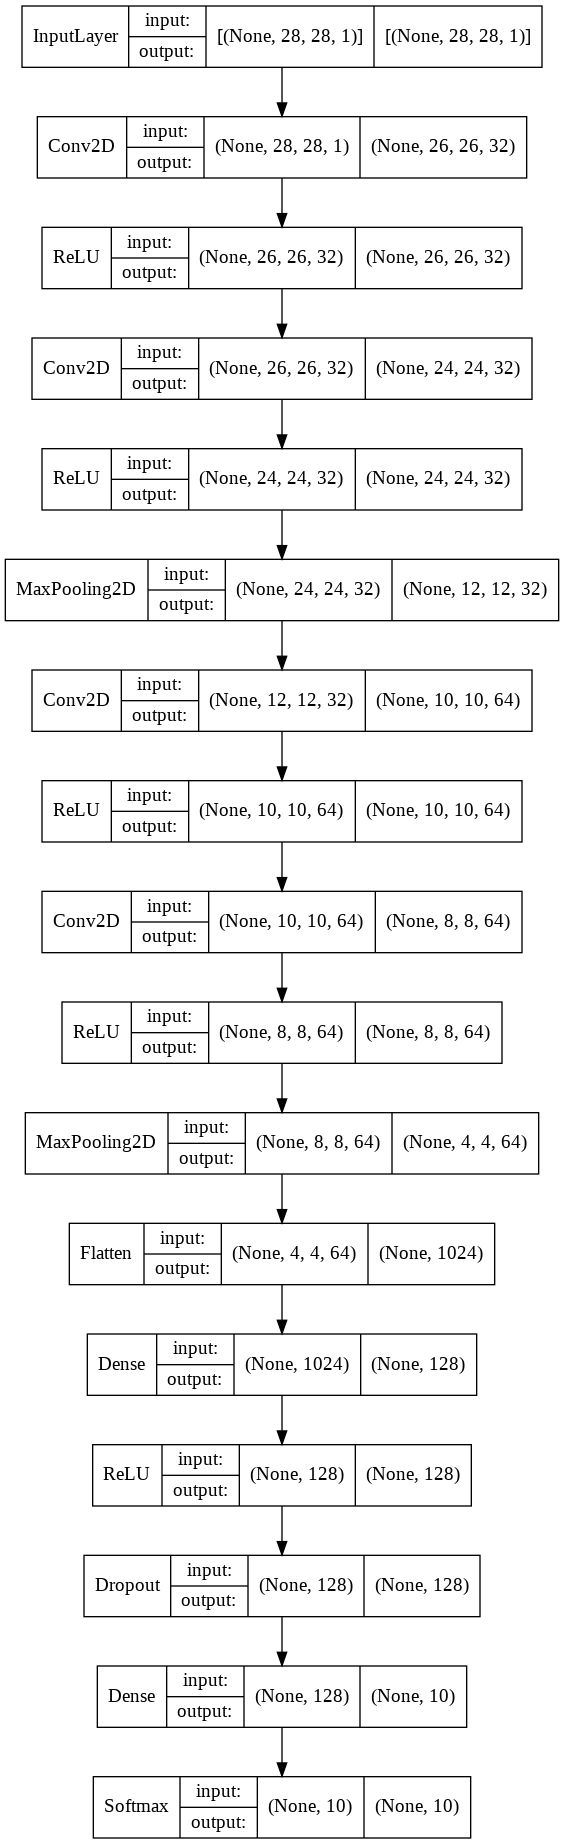

In [ ]:
target = MNISTConvTarget()
tf.keras.utils.plot_model(target.model, show_shapes=True, show_layer_names=False)

In [ ]:
weights_path = f'{WEIGHTS_DIR}/mnist_conv_target_20220106120545.h5'

target.built = True
target.load_weights(weights_path)

### Training

In each training step, the generator receives a batch of training set images $\mathbf{x}$ as input and uses it to generate a batch of adversarial perturbations $G(\mathbf{x})$.
The adversarial images are obtained by combining the training set images with the perturbations: $\mathbf{x}_{adv} = \mathbf{x} + G(\mathbf{x})$ (making sure that the values remain in $[-1, 1]$).

The target model classifies the adversarial images, and the resulting class probabilities $f(\mathbf{x}_{adv})$ are used for calculating the adversarial loss.

The discriminator is then used to classify real images (from the training set) and adversarial images (produced by the generator).

The loss is calculated for the discriminator and the generator respectively, and the resulting gradients are used to update them.

#### Discriminator loss

The discriminator's loss quantifies how well it distinguishes between real images $\mathbf{x}$ and generated images $\mathbf{x} + G(\mathbf{x})$.
As such, it is a sum of the losses computed on the real and fake outputs:

$\mathcal{L}_D = \mathcal{L_{D,\mathrm{real}}} + \mathcal{L_{D,\mathrm{fake}}}$

For the real component, the discriminator's predictions are compared to an array of 1s, and for the fake outputs to an array of 0s:

$\mathcal{L_{D,\mathrm{real}}} = BCE(\mathbf{1}, D(\mathbf{x}))$

$\mathcal{L_{D,\mathrm{fake}}} = BCE(\mathbf{0}, D(\mathbf{x} + G(\mathbf{x})))$,

where $BCE$ stands for the binary cross-entropy loss function.

#### Generator loss

In the adversarial attack setting, the generator loss $\mathcal{L}_G$, besides quantifying how well the generator fools the discriminator, also needs to quantify the successfulness of the generated adversarial images (i.e. how well do they fool the target into classifying them as the desired target label $t$).

The adversarial component of the loss is calculated according to the formula found in [Carlini and Wagner (2017b)](https://nicholas.carlini.com/papers/2017_sp_nnrobustattacks.pdf).
For a single adversarial image $x_{adv}$ and the corresponding class probabilities obtained from the target model $f(x_{adv})$, the adversarial loss is given as:

$\mathcal{L_{x_{adv}}} = \mathrm{max}(\mathrm{max}_{i \ne t} f(x_{adv})_i - f(x_{adv})_t,\ 0)$

Since we are training on batches of data, the final adversarial loss $\mathcal{L_{adv}}$ is a sum of all the individual adversarial losses for the adversarial images generated in the batch.

Additionally, a soft hinge loss on the L2 norm of the perturbations is added to bound their magnitude. For a single adversarial perturbation:

$\mathcal{L}_{perturb, x} = \mathrm{max}(||G(x)||_2 - \mathrm{bound}, 0)$,

where $\mathrm{bound}$ is a user-specified parameter (e.g. $0.3$).
Again, because we are dealing with batched data, the final perturbation loss $\mathcal{L}_{perturb}$ is a mean of all the individual perturbation losses for the batch.

The total generator loss is then:

$\mathcal{L}_G = \mathcal{L_{adv}} + \lambda_{gan}BCE(\mathbf{1}, D(\mathbf{x} + G(\mathbf{x}))) + \lambda_{perturb}\mathcal{L}_{perturb}$,

where $\lambda_{gan}$ and $\lambda_{perturb}$ are user-defined parameters that control the importance of the original generator loss and perturbation loss respectively.

Create the `AdvGAN` model:

In [ ]:
advgan = AdvGAN(
    target=target,
    discriminator=discriminator,
    generator=generator
)

Compile the model by adding the respective optimizers (two are needed because the discriminator and generator train seperately), the loss functions, and the $\lambda$ parameters:

Note that `from_logits` needs to be set to `True` as the discriminator outputs logits instead of probabilities.

In [ ]:
PERTURB_BOUND = None

advgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),

    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1),
    adv_loss_fn=carlini_wagner_loss_fn(target_label=TARGET_LABEL),
    perturb_loss_fn=l2_norm_soft_hinge_loss_fn(bound=0.1),

    lambda_gan=1,
    lambda_perturb=1,
    perturb_bound=PERTURB_BOUND
)

Create a callback that periodically saves generated images:

In [ ]:
callback = ImageAdvGANCallback(
    train_images[:5],
    path_prefix=f'{IMAGES_DIR}/{BASE_FILENAME}',
    perturb_bound=PERTURB_BOUND
)

Finally, train the model:

Epoch 1/50
421/421 [==============================] - ETA: 0s - d_loss: 0.6928 - g_loss: 127.9628 - g_gan_loss: 0.6941 - g_adv_loss: 127.2685 - g_perturb_loss: 8.8546e-05

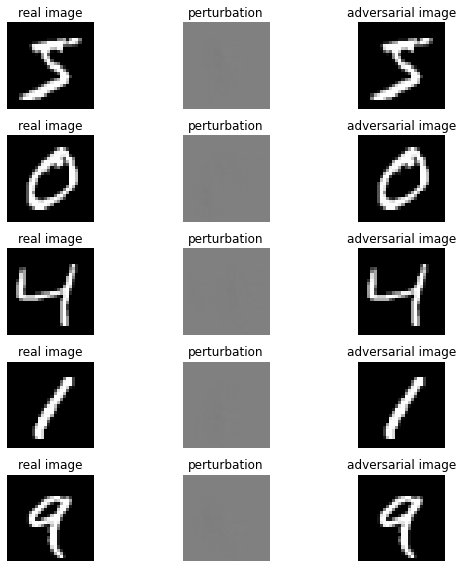

421/421 [==============================] - 39s 31ms/step - d_loss: 0.6928 - g_loss: 127.9193 - g_gan_loss: 0.6941 - g_adv_loss: 127.2251 - g_perturb_loss: 8.8695e-05
Epoch 2/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.6924 - g_loss: 128.0065 - g_gan_loss: 0.6950 - g_adv_loss: 127.3114 - g_perturb_loss: 1.0520e-04

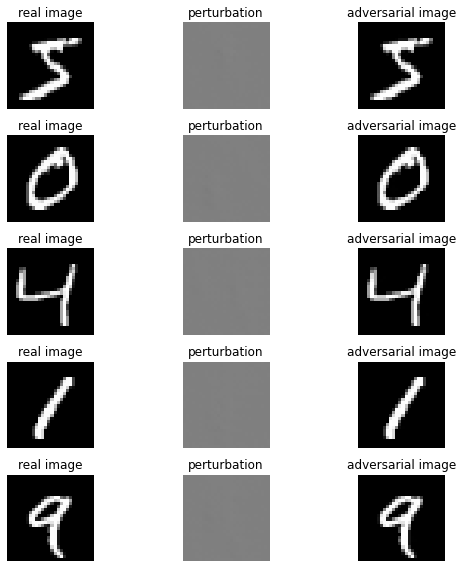

421/421 [==============================] - 12s 28ms/step - d_loss: 0.6924 - g_loss: 127.9183 - g_gan_loss: 0.6950 - g_adv_loss: 127.2232 - g_perturb_loss: 1.0470e-04
Epoch 3/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.6924 - g_loss: 128.0026 - g_gan_loss: 0.6955 - g_adv_loss: 127.3067 - g_perturb_loss: 3.1810e-04

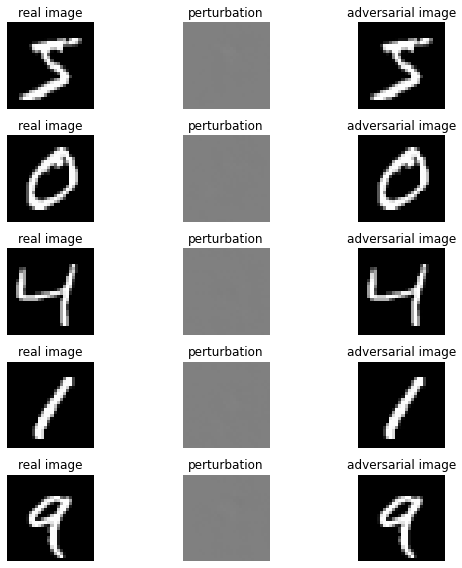

421/421 [==============================] - 12s 29ms/step - d_loss: 0.6924 - g_loss: 127.9152 - g_gan_loss: 0.6955 - g_adv_loss: 127.2194 - g_perturb_loss: 3.1690e-04
Epoch 4/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.6924 - g_loss: 127.9983 - g_gan_loss: 0.6952 - g_adv_loss: 127.3022 - g_perturb_loss: 9.4546e-04

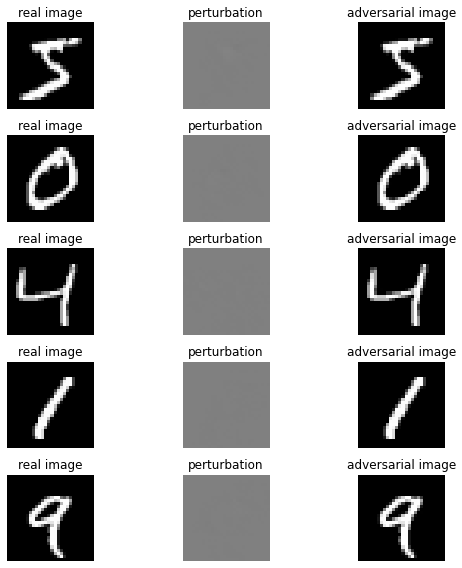

421/421 [==============================] - 12s 29ms/step - d_loss: 0.6924 - g_loss: 127.9098 - g_gan_loss: 0.6952 - g_adv_loss: 127.2137 - g_perturb_loss: 9.4098e-04
Epoch 5/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.6925 - g_loss: 127.9937 - g_gan_loss: 0.6954 - g_adv_loss: 127.2959 - g_perturb_loss: 0.0024

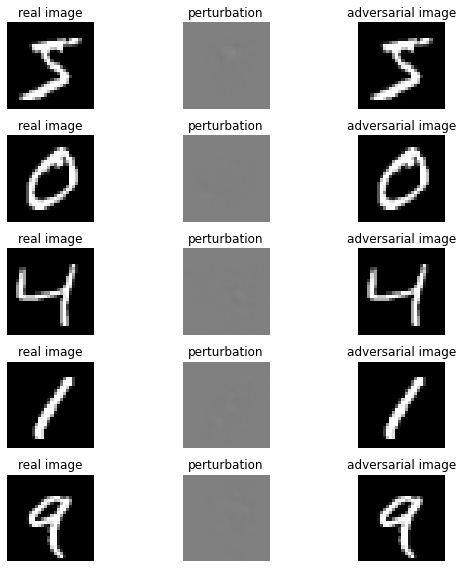

421/421 [==============================] - 12s 29ms/step - d_loss: 0.6925 - g_loss: 127.9032 - g_gan_loss: 0.6952 - g_adv_loss: 127.2056 - g_perturb_loss: 0.0024
Epoch 6/50
421/421 [==============================] - ETA: 0s - d_loss: 0.6926 - g_loss: 127.9397 - g_gan_loss: 0.6948 - g_adv_loss: 127.2364 - g_perturb_loss: 0.0086

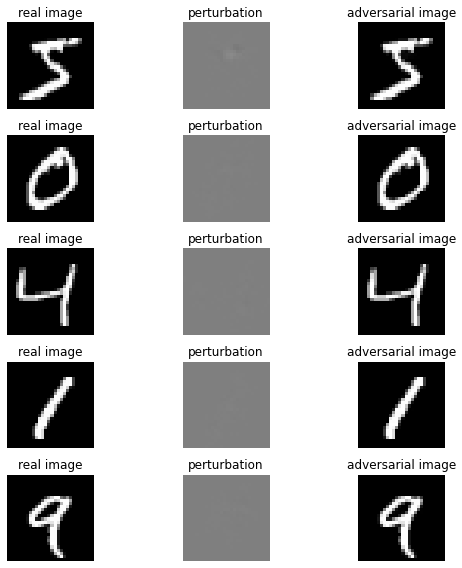

421/421 [==============================] - 13s 32ms/step - d_loss: 0.6926 - g_loss: 127.8946 - g_gan_loss: 0.6948 - g_adv_loss: 127.1913 - g_perturb_loss: 0.0086
Epoch 7/50
421/421 [==============================] - ETA: 0s - d_loss: 0.6923 - g_loss: 127.9179 - g_gan_loss: 0.6956 - g_adv_loss: 127.1907 - g_perturb_loss: 0.0317

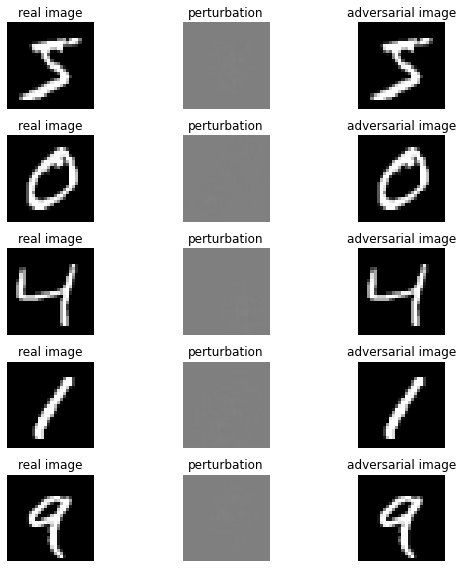

421/421 [==============================] - 12s 29ms/step - d_loss: 0.6923 - g_loss: 127.8746 - g_gan_loss: 0.6955 - g_adv_loss: 127.1474 - g_perturb_loss: 0.0316
Epoch 8/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.3351 - g_loss: 48.8212 - g_gan_loss: 2.2371 - g_adv_loss: 39.1441 - g_perturb_loss: 7.4400

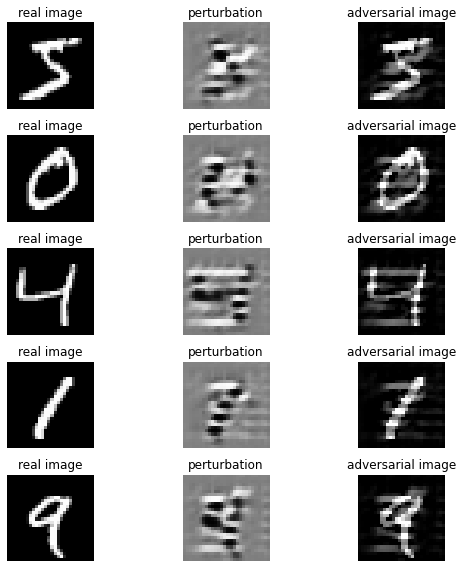

421/421 [==============================] - 13s 30ms/step - d_loss: 0.3345 - g_loss: 48.6502 - g_gan_loss: 2.2401 - g_adv_loss: 38.9610 - g_perturb_loss: 7.4492
Epoch 9/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1995 - g_loss: 11.9287 - g_gan_loss: 2.8465 - g_adv_loss: 0.4449 - g_perturb_loss: 8.6373

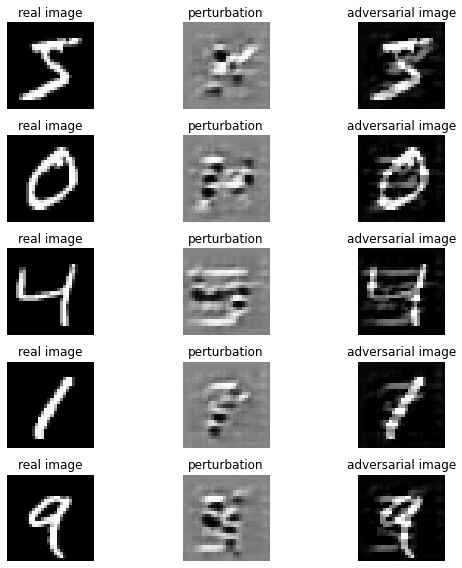

421/421 [==============================] - 12s 29ms/step - d_loss: 0.1995 - g_loss: 11.9271 - g_gan_loss: 2.8465 - g_adv_loss: 0.4453 - g_perturb_loss: 8.6353
Epoch 10/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1994 - g_loss: 10.9459 - g_gan_loss: 2.8481 - g_adv_loss: 0.3310 - g_perturb_loss: 7.7668

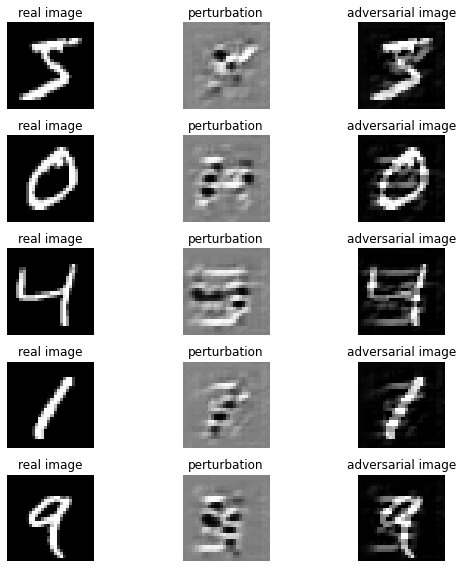

421/421 [==============================] - 13s 30ms/step - d_loss: 0.1994 - g_loss: 10.9455 - g_gan_loss: 2.8482 - g_adv_loss: 0.3302 - g_perturb_loss: 7.7671
Epoch 11/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1997 - g_loss: 10.3795 - g_gan_loss: 2.8446 - g_adv_loss: 0.2790 - g_perturb_loss: 7.2558

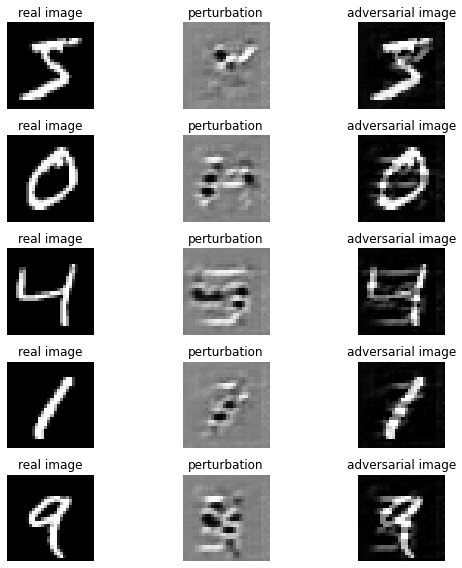

421/421 [==============================] - 13s 31ms/step - d_loss: 0.1997 - g_loss: 10.3776 - g_gan_loss: 2.8445 - g_adv_loss: 0.2783 - g_perturb_loss: 7.2548
Epoch 12/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1993 - g_loss: 10.0720 - g_gan_loss: 2.8496 - g_adv_loss: 0.2379 - g_perturb_loss: 6.9845

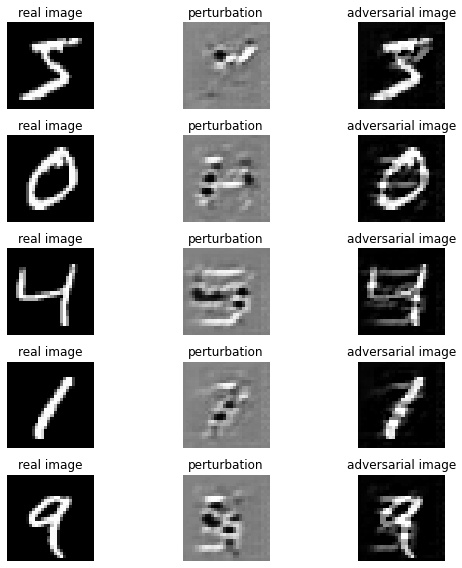

421/421 [==============================] - 13s 31ms/step - d_loss: 0.1993 - g_loss: 10.0710 - g_gan_loss: 2.8496 - g_adv_loss: 0.2373 - g_perturb_loss: 6.9841
Epoch 13/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.1991 - g_loss: 9.7908 - g_gan_loss: 2.8497 - g_adv_loss: 0.2150 - g_perturb_loss: 6.7260

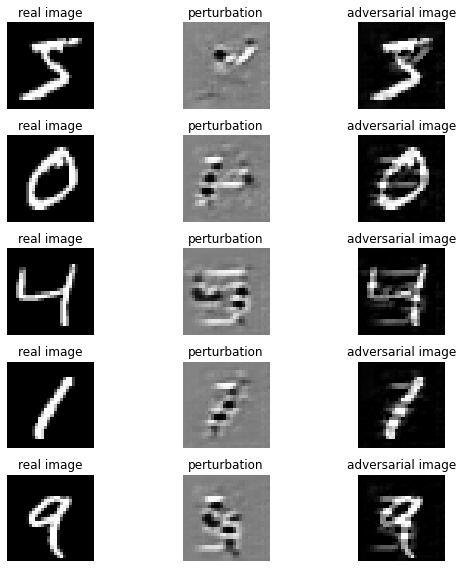

421/421 [==============================] - 13s 31ms/step - d_loss: 0.1991 - g_loss: 9.7908 - g_gan_loss: 2.8499 - g_adv_loss: 0.2140 - g_perturb_loss: 6.7270
Epoch 14/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2000 - g_loss: 9.6894 - g_gan_loss: 2.8456 - g_adv_loss: 0.1921 - g_perturb_loss: 6.6517

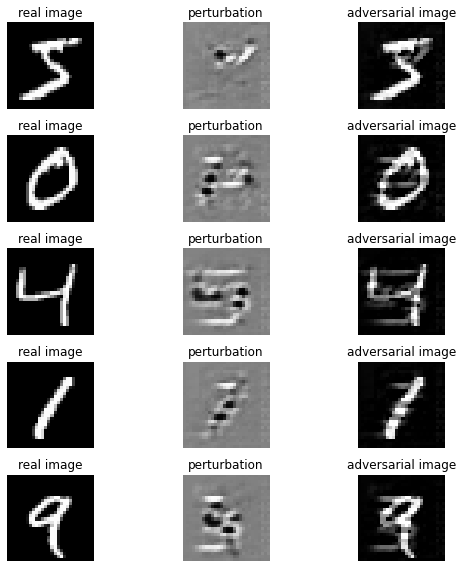

421/421 [==============================] - 13s 31ms/step - d_loss: 0.2000 - g_loss: 9.6886 - g_gan_loss: 2.8455 - g_adv_loss: 0.1917 - g_perturb_loss: 6.6514
Epoch 15/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1991 - g_loss: 9.5346 - g_gan_loss: 2.8494 - g_adv_loss: 0.1581 - g_perturb_loss: 6.5271

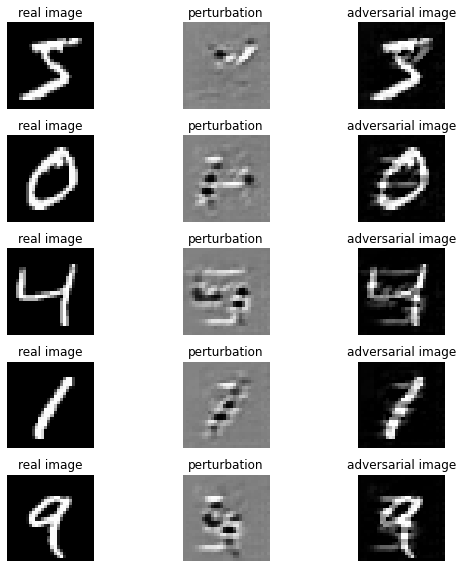

421/421 [==============================] - 13s 31ms/step - d_loss: 0.1991 - g_loss: 9.5345 - g_gan_loss: 2.8494 - g_adv_loss: 0.1578 - g_perturb_loss: 6.5273
Epoch 16/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1990 - g_loss: 9.3909 - g_gan_loss: 2.8484 - g_adv_loss: 0.1784 - g_perturb_loss: 6.3641

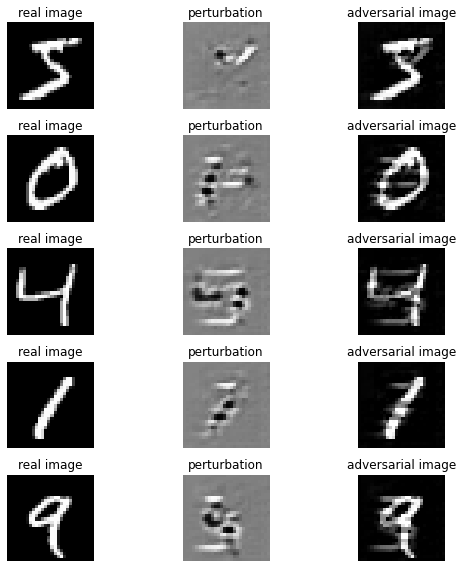

421/421 [==============================] - 13s 31ms/step - d_loss: 0.1990 - g_loss: 9.3903 - g_gan_loss: 2.8485 - g_adv_loss: 0.1780 - g_perturb_loss: 6.3639
Epoch 17/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.1990 - g_loss: 9.3089 - g_gan_loss: 2.8491 - g_adv_loss: 0.1698 - g_perturb_loss: 6.2900

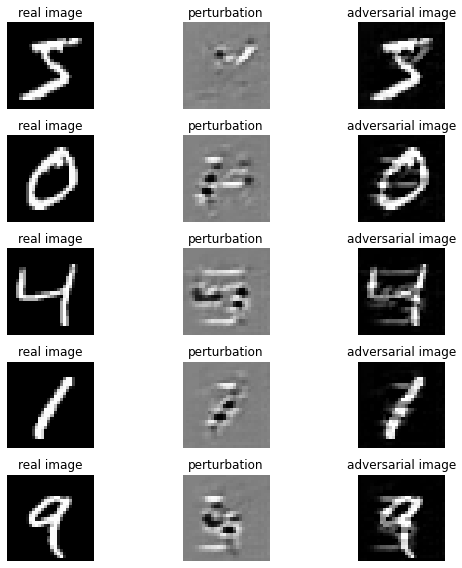

421/421 [==============================] - 14s 32ms/step - d_loss: 0.1990 - g_loss: 9.3091 - g_gan_loss: 2.8492 - g_adv_loss: 0.1693 - g_perturb_loss: 6.2906
Epoch 18/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2004 - g_loss: 9.2180 - g_gan_loss: 2.8422 - g_adv_loss: 0.1546 - g_perturb_loss: 6.2211

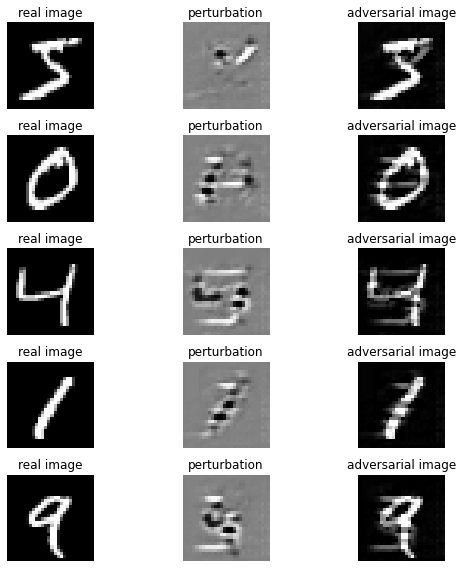

421/421 [==============================] - 13s 31ms/step - d_loss: 0.2004 - g_loss: 9.2183 - g_gan_loss: 2.8422 - g_adv_loss: 0.1543 - g_perturb_loss: 6.2219
Epoch 19/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1992 - g_loss: 9.2109 - g_gan_loss: 2.8490 - g_adv_loss: 0.1560 - g_perturb_loss: 6.2058

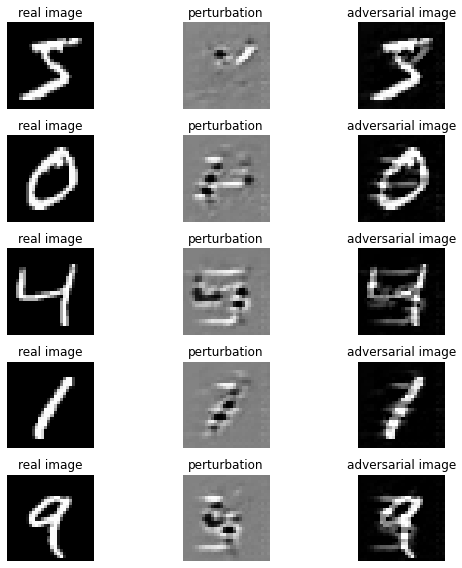

421/421 [==============================] - 13s 31ms/step - d_loss: 0.1992 - g_loss: 9.2114 - g_gan_loss: 2.8491 - g_adv_loss: 0.1557 - g_perturb_loss: 6.2066
Epoch 20/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1990 - g_loss: 9.1312 - g_gan_loss: 2.8494 - g_adv_loss: 0.1591 - g_perturb_loss: 6.1227

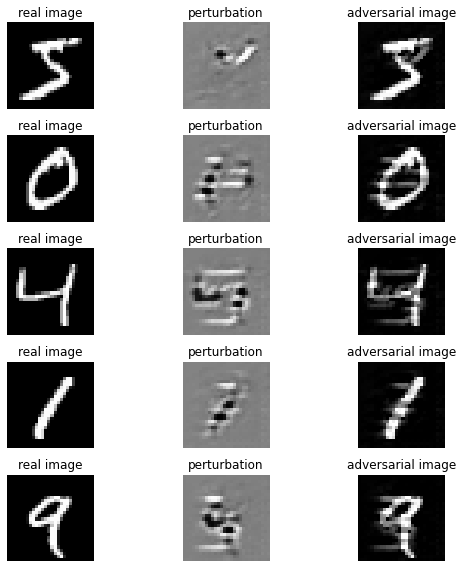

421/421 [==============================] - 13s 32ms/step - d_loss: 0.1990 - g_loss: 9.1309 - g_gan_loss: 2.8494 - g_adv_loss: 0.1590 - g_perturb_loss: 6.1225
Epoch 21/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1989 - g_loss: 9.0635 - g_gan_loss: 2.8487 - g_adv_loss: 0.1413 - g_perturb_loss: 6.0735

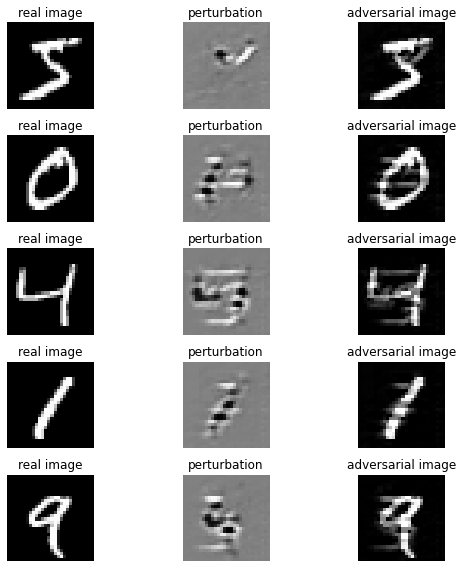

421/421 [==============================] - 13s 32ms/step - d_loss: 0.1989 - g_loss: 9.0630 - g_gan_loss: 2.8487 - g_adv_loss: 0.1410 - g_perturb_loss: 6.0734
Epoch 22/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.1990 - g_loss: 9.0253 - g_gan_loss: 2.8482 - g_adv_loss: 0.1489 - g_perturb_loss: 6.0282

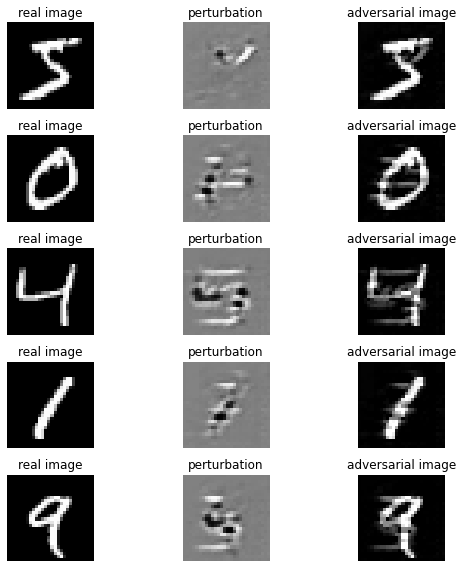

421/421 [==============================] - 13s 32ms/step - d_loss: 0.1990 - g_loss: 9.0275 - g_gan_loss: 2.8483 - g_adv_loss: 0.1514 - g_perturb_loss: 6.0279
Epoch 23/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1989 - g_loss: 8.9107 - g_gan_loss: 2.8481 - g_adv_loss: 0.1274 - g_perturb_loss: 5.9351

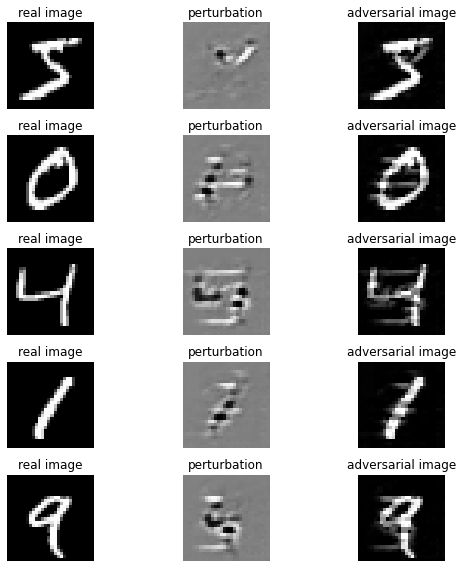

421/421 [==============================] - 13s 32ms/step - d_loss: 0.1989 - g_loss: 8.9103 - g_gan_loss: 2.8482 - g_adv_loss: 0.1271 - g_perturb_loss: 5.9350
Epoch 24/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1988 - g_loss: 8.8907 - g_gan_loss: 2.8486 - g_adv_loss: 0.1232 - g_perturb_loss: 5.9190

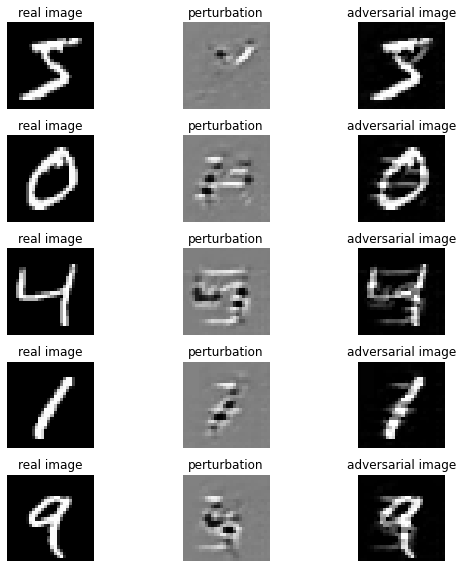

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1988 - g_loss: 8.8909 - g_gan_loss: 2.8486 - g_adv_loss: 0.1230 - g_perturb_loss: 5.9194
Epoch 25/50
421/421 [==============================] - ETA: 0s - d_loss: 0.2001 - g_loss: 8.9243 - g_gan_loss: 2.8437 - g_adv_loss: 0.1383 - g_perturb_loss: 5.9423

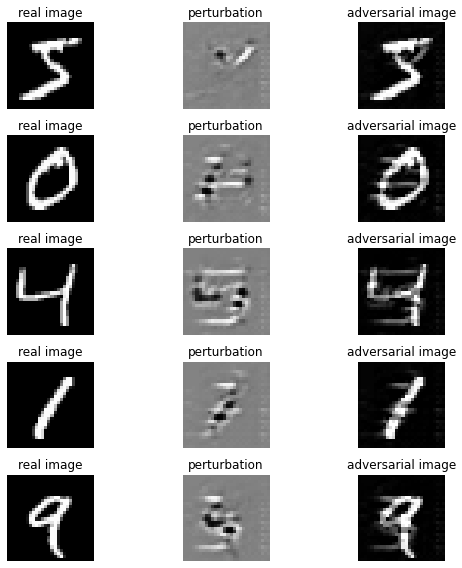

421/421 [==============================] - 13s 32ms/step - d_loss: 0.2001 - g_loss: 8.9243 - g_gan_loss: 2.8438 - g_adv_loss: 0.1386 - g_perturb_loss: 5.9419
Epoch 26/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1988 - g_loss: 8.8451 - g_gan_loss: 2.8493 - g_adv_loss: 0.1224 - g_perturb_loss: 5.8734

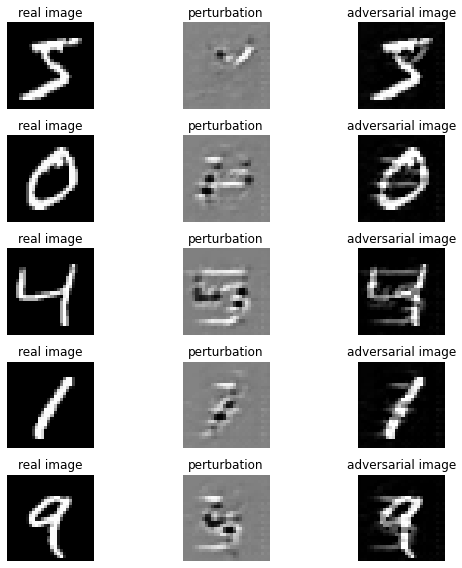

421/421 [==============================] - 14s 34ms/step - d_loss: 0.1988 - g_loss: 8.8447 - g_gan_loss: 2.8492 - g_adv_loss: 0.1221 - g_perturb_loss: 5.8734
Epoch 27/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1988 - g_loss: 8.8297 - g_gan_loss: 2.8490 - g_adv_loss: 0.1093 - g_perturb_loss: 5.8714

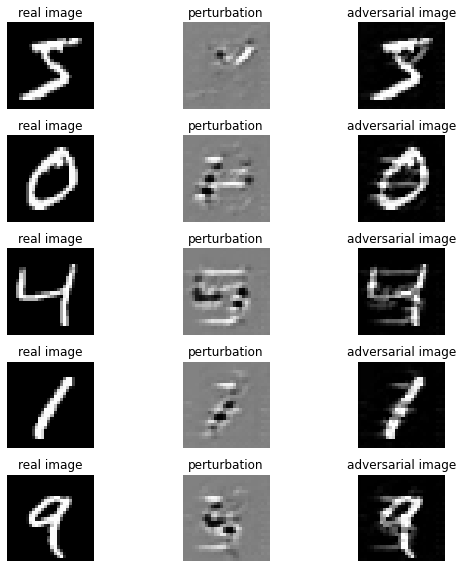

421/421 [==============================] - 14s 32ms/step - d_loss: 0.1988 - g_loss: 8.8297 - g_gan_loss: 2.8490 - g_adv_loss: 0.1090 - g_perturb_loss: 5.8717
Epoch 28/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1988 - g_loss: 8.7905 - g_gan_loss: 2.8483 - g_adv_loss: 0.1204 - g_perturb_loss: 5.8218

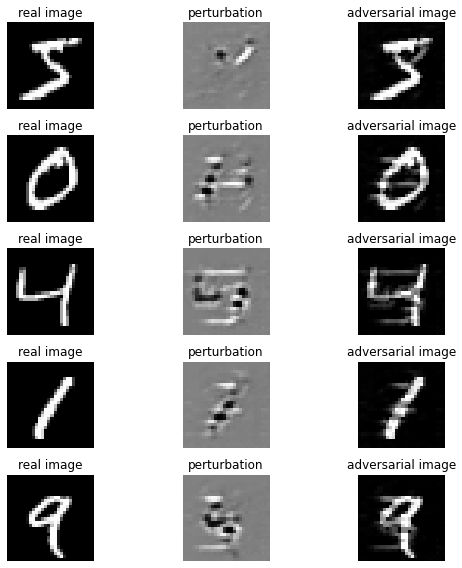

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1988 - g_loss: 8.7910 - g_gan_loss: 2.8482 - g_adv_loss: 0.1211 - g_perturb_loss: 5.8216
Epoch 29/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1988 - g_loss: 8.7336 - g_gan_loss: 2.8486 - g_adv_loss: 0.1199 - g_perturb_loss: 5.7651

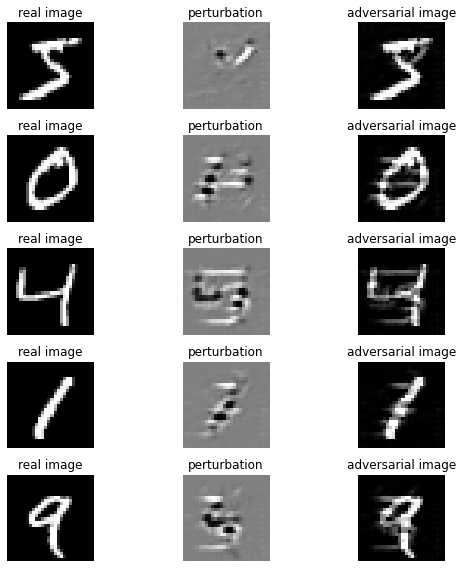

421/421 [==============================] - 14s 32ms/step - d_loss: 0.1988 - g_loss: 8.7343 - g_gan_loss: 2.8486 - g_adv_loss: 0.1196 - g_perturb_loss: 5.7661
Epoch 30/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1991 - g_loss: 8.7399 - g_gan_loss: 2.8474 - g_adv_loss: 0.1100 - g_perturb_loss: 5.7825

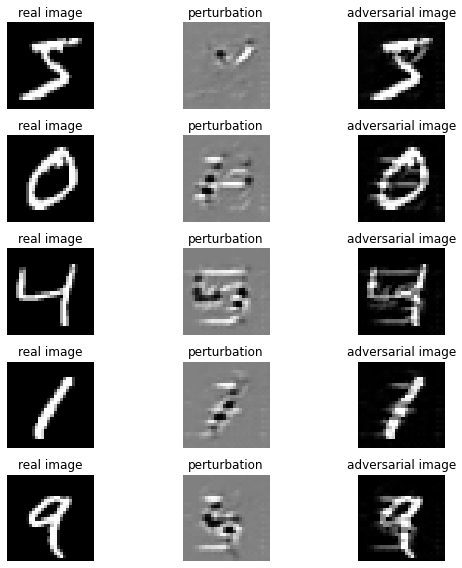

421/421 [==============================] - 14s 32ms/step - d_loss: 0.1991 - g_loss: 8.7404 - g_gan_loss: 2.8474 - g_adv_loss: 0.1097 - g_perturb_loss: 5.7833
Epoch 31/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1988 - g_loss: 8.7238 - g_gan_loss: 2.8480 - g_adv_loss: 0.1155 - g_perturb_loss: 5.7603

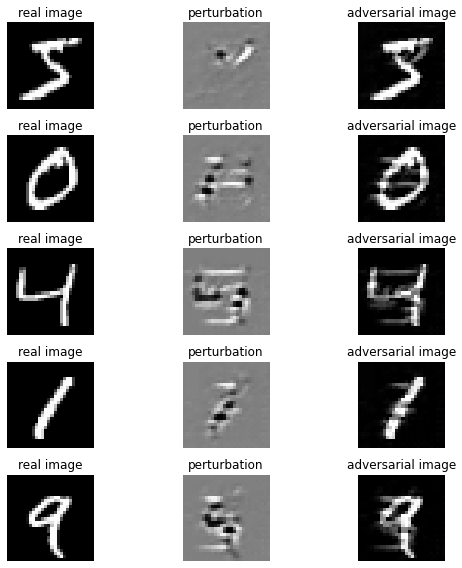

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1988 - g_loss: 8.7234 - g_gan_loss: 2.8479 - g_adv_loss: 0.1157 - g_perturb_loss: 5.7598
Epoch 32/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.1988 - g_loss: 8.6775 - g_gan_loss: 2.8489 - g_adv_loss: 0.1218 - g_perturb_loss: 5.7068

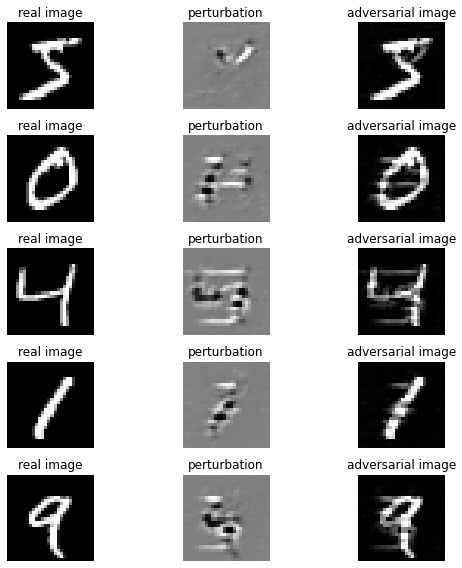

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1988 - g_loss: 8.6781 - g_gan_loss: 2.8489 - g_adv_loss: 0.1227 - g_perturb_loss: 5.7065
Epoch 33/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1987 - g_loss: 8.6847 - g_gan_loss: 2.8486 - g_adv_loss: 0.1100 - g_perturb_loss: 5.7262

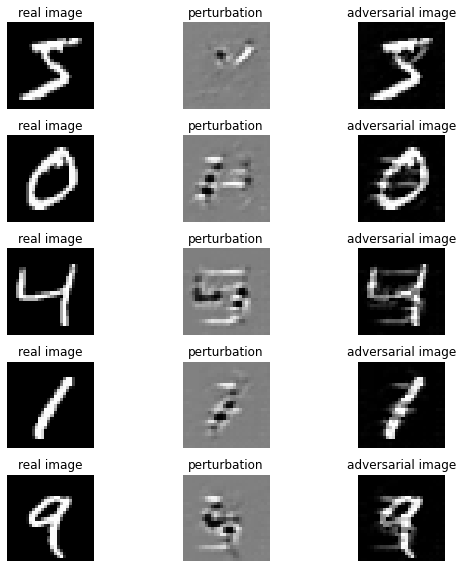

421/421 [==============================] - 14s 34ms/step - d_loss: 0.1987 - g_loss: 8.6848 - g_gan_loss: 2.8485 - g_adv_loss: 0.1101 - g_perturb_loss: 5.7262
Epoch 34/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1991 - g_loss: 8.6296 - g_gan_loss: 2.8476 - g_adv_loss: 0.1044 - g_perturb_loss: 5.6777

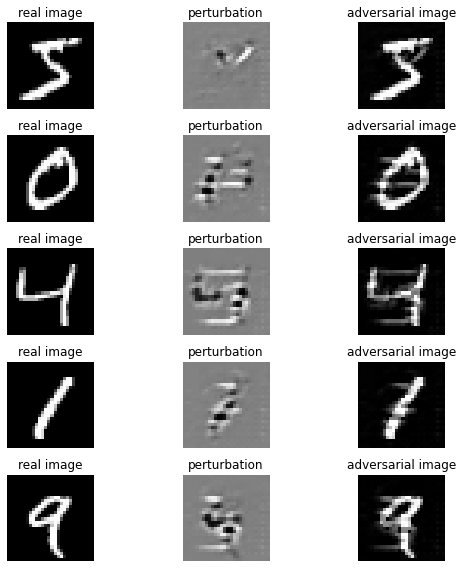

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1991 - g_loss: 8.6299 - g_gan_loss: 2.8476 - g_adv_loss: 0.1049 - g_perturb_loss: 5.6775
Epoch 35/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1987 - g_loss: 8.6414 - g_gan_loss: 2.8488 - g_adv_loss: 0.1001 - g_perturb_loss: 5.6925

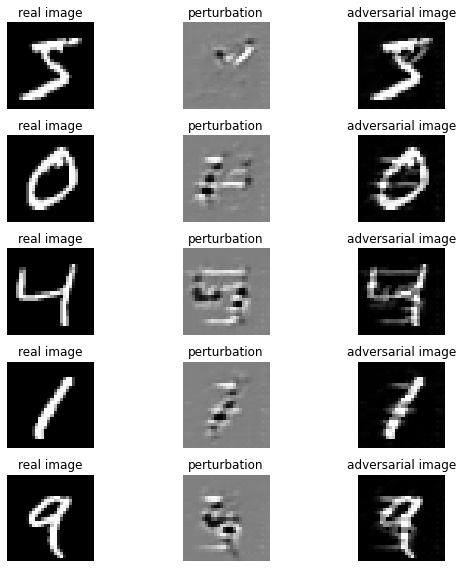

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1987 - g_loss: 8.6412 - g_gan_loss: 2.8488 - g_adv_loss: 0.0998 - g_perturb_loss: 5.6926
Epoch 36/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.1988 - g_loss: 8.6284 - g_gan_loss: 2.8484 - g_adv_loss: 0.1157 - g_perturb_loss: 5.6642

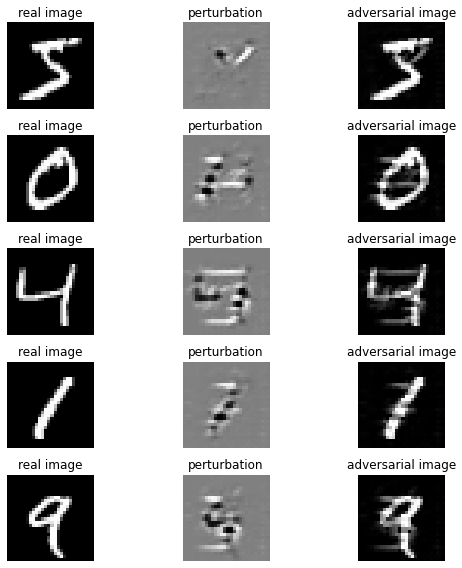

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1988 - g_loss: 8.6286 - g_gan_loss: 2.8484 - g_adv_loss: 0.1152 - g_perturb_loss: 5.6650
Epoch 37/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1988 - g_loss: 8.5565 - g_gan_loss: 2.8478 - g_adv_loss: 0.0963 - g_perturb_loss: 5.6124

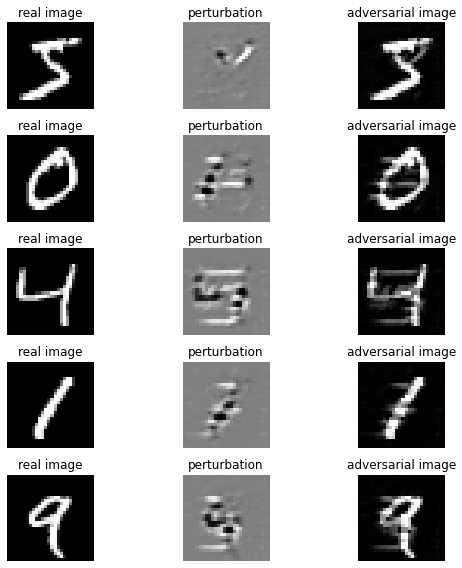

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1988 - g_loss: 8.5562 - g_gan_loss: 2.8478 - g_adv_loss: 0.0961 - g_perturb_loss: 5.6123
Epoch 38/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1990 - g_loss: 8.5976 - g_gan_loss: 2.8481 - g_adv_loss: 0.1014 - g_perturb_loss: 5.6481

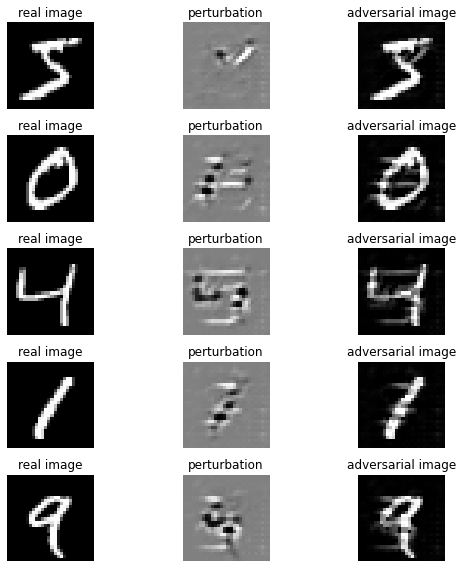

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1990 - g_loss: 8.5984 - g_gan_loss: 2.8482 - g_adv_loss: 0.1016 - g_perturb_loss: 5.6486
Epoch 39/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.1987 - g_loss: 8.5982 - g_gan_loss: 2.8491 - g_adv_loss: 0.0930 - g_perturb_loss: 5.6561

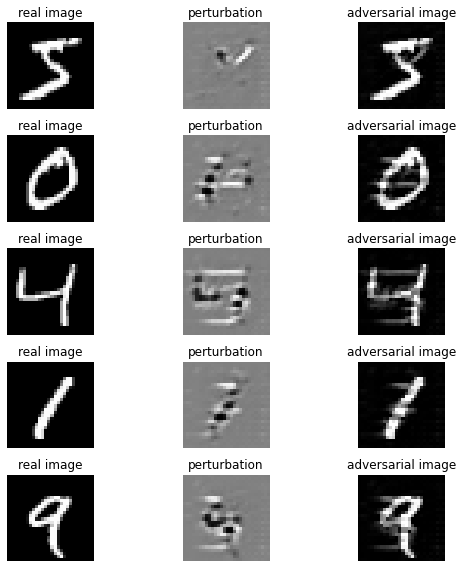

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1987 - g_loss: 8.5981 - g_gan_loss: 2.8491 - g_adv_loss: 0.0938 - g_perturb_loss: 5.6552
Epoch 40/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1986 - g_loss: 8.5604 - g_gan_loss: 2.8487 - g_adv_loss: 0.0867 - g_perturb_loss: 5.6250

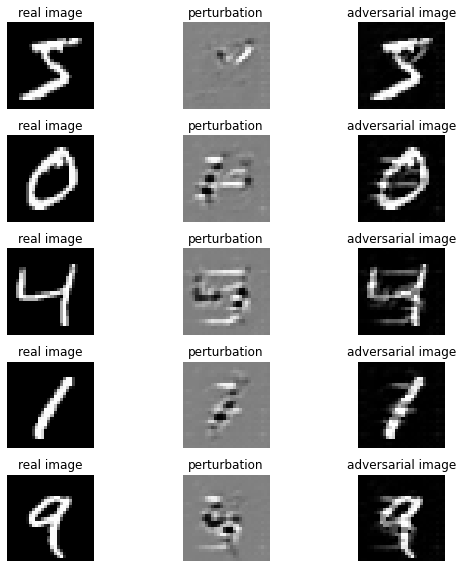

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1986 - g_loss: 8.5608 - g_gan_loss: 2.8487 - g_adv_loss: 0.0873 - g_perturb_loss: 5.6248
Epoch 41/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1988 - g_loss: 8.5232 - g_gan_loss: 2.8482 - g_adv_loss: 0.0885 - g_perturb_loss: 5.5866

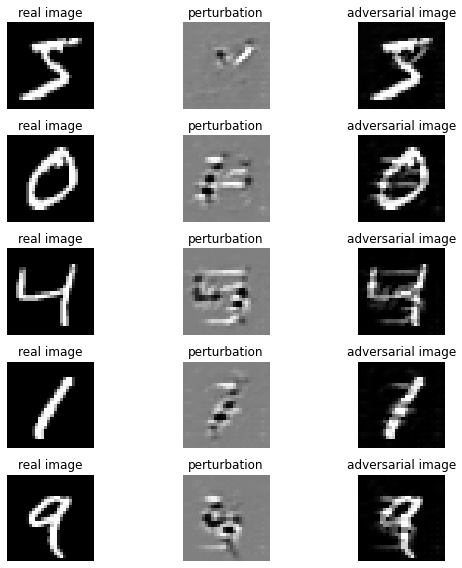

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1988 - g_loss: 8.5235 - g_gan_loss: 2.8482 - g_adv_loss: 0.0883 - g_perturb_loss: 5.5871
Epoch 42/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.1989 - g_loss: 8.5336 - g_gan_loss: 2.8482 - g_adv_loss: 0.1055 - g_perturb_loss: 5.5800

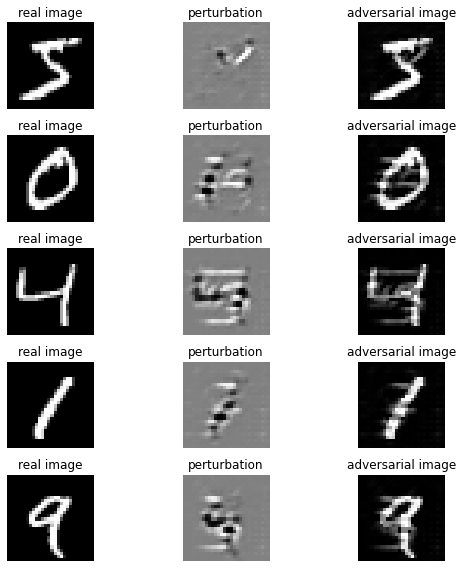

421/421 [==============================] - 14s 34ms/step - d_loss: 0.1989 - g_loss: 8.5344 - g_gan_loss: 2.8481 - g_adv_loss: 0.1050 - g_perturb_loss: 5.5814
Epoch 43/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.1987 - g_loss: 8.5255 - g_gan_loss: 2.8488 - g_adv_loss: 0.0982 - g_perturb_loss: 5.5785

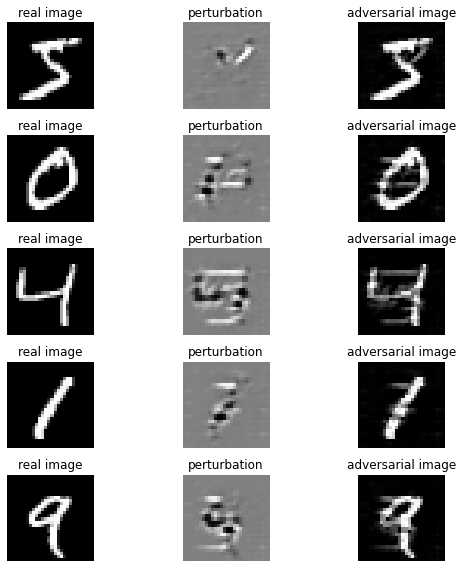

421/421 [==============================] - 15s 34ms/step - d_loss: 0.1987 - g_loss: 8.5251 - g_gan_loss: 2.8489 - g_adv_loss: 0.0977 - g_perturb_loss: 5.5785
Epoch 44/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1986 - g_loss: 8.4937 - g_gan_loss: 2.8489 - g_adv_loss: 0.0839 - g_perturb_loss: 5.5610

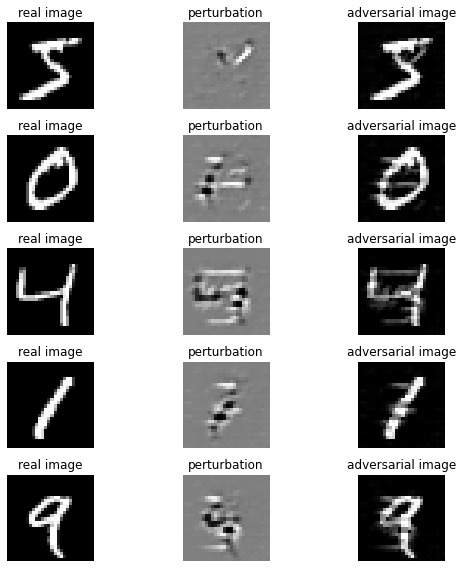

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1986 - g_loss: 8.4941 - g_gan_loss: 2.8489 - g_adv_loss: 0.0845 - g_perturb_loss: 5.5607
Epoch 45/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.1987 - g_loss: 8.4487 - g_gan_loss: 2.8485 - g_adv_loss: 0.0879 - g_perturb_loss: 5.5123

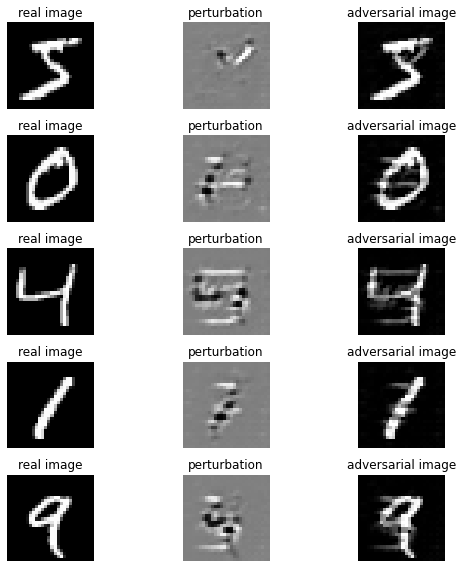

421/421 [==============================] - 14s 33ms/step - d_loss: 0.1987 - g_loss: 8.4483 - g_gan_loss: 2.8486 - g_adv_loss: 0.0875 - g_perturb_loss: 5.5122
Epoch 46/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.1986 - g_loss: 8.4623 - g_gan_loss: 2.8485 - g_adv_loss: 0.0841 - g_perturb_loss: 5.5297

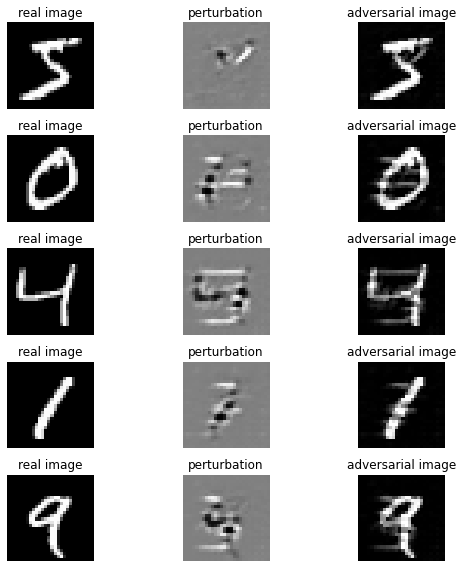

421/421 [==============================] - 14s 34ms/step - d_loss: 0.1986 - g_loss: 8.4641 - g_gan_loss: 2.8484 - g_adv_loss: 0.0867 - g_perturb_loss: 5.5290
Epoch 47/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1987 - g_loss: 8.4453 - g_gan_loss: 2.8485 - g_adv_loss: 0.0884 - g_perturb_loss: 5.5083

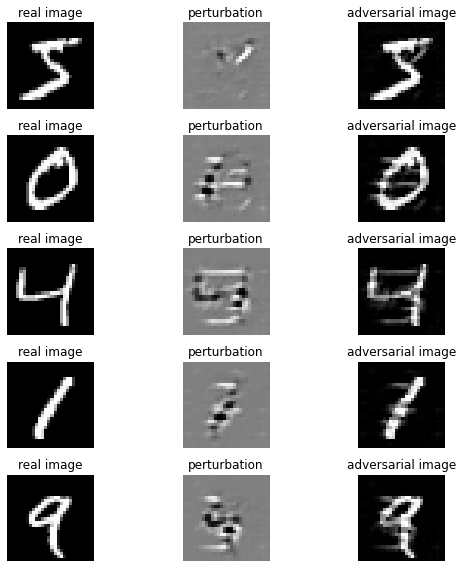

421/421 [==============================] - 14s 34ms/step - d_loss: 0.1987 - g_loss: 8.4454 - g_gan_loss: 2.8485 - g_adv_loss: 0.0882 - g_perturb_loss: 5.5086
Epoch 48/50
421/421 [==============================] - ETA: 0s - d_loss: 0.1987 - g_loss: 8.4664 - g_gan_loss: 2.8487 - g_adv_loss: 0.0816 - g_perturb_loss: 5.5361

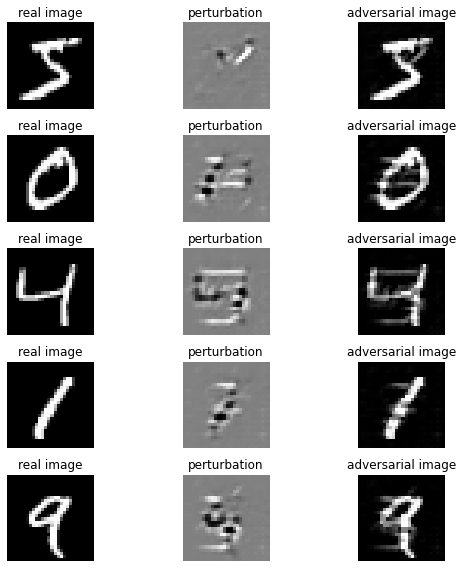

421/421 [==============================] - 14s 34ms/step - d_loss: 0.1987 - g_loss: 8.4659 - g_gan_loss: 2.8487 - g_adv_loss: 0.0814 - g_perturb_loss: 5.5358
Epoch 49/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.1986 - g_loss: 8.4432 - g_gan_loss: 2.8487 - g_adv_loss: 0.0956 - g_perturb_loss: 5.4989

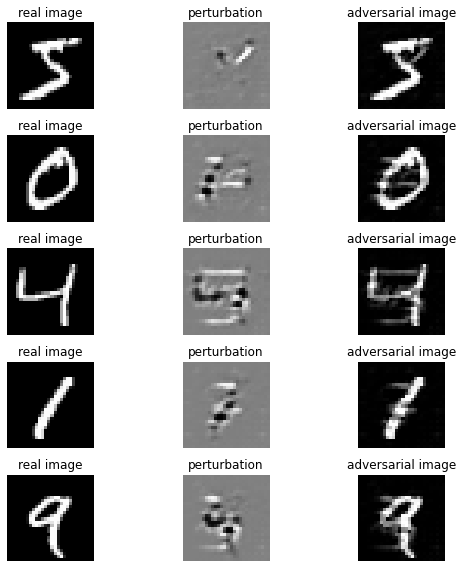

421/421 [==============================] - 14s 34ms/step - d_loss: 0.1986 - g_loss: 8.4428 - g_gan_loss: 2.8487 - g_adv_loss: 0.0959 - g_perturb_loss: 5.4982
Epoch 50/50
420/421 [============================>.] - ETA: 0s - d_loss: 0.1986 - g_loss: 8.4117 - g_gan_loss: 2.8484 - g_adv_loss: 0.0880 - g_perturb_loss: 5.4753

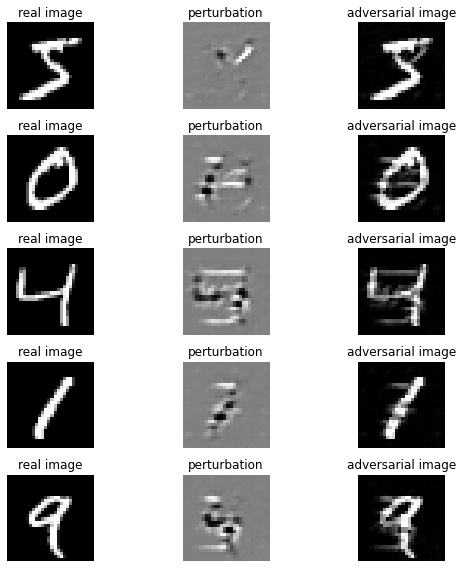

421/421 [==============================] - 15s 34ms/step - d_loss: 0.1986 - g_loss: 8.4112 - g_gan_loss: 2.8484 - g_adv_loss: 0.0876 - g_perturb_loss: 5.4752


In [ ]:
history = advgan.fit(
    dataset,
    epochs=50,
    callbacks=[callback]
)

In [ ]:
weights_path = f'{WEIGHTS_DIR}/{BASE_FILENAME}_{time.strftime("%Y%m%d%H%M%S")}.h5'
advgan.save_weights(weights_path)

print(f'Weights saved as {weights_path}')

Weights saved as weights/advgan_mnist_20220603134113.h5


In [ ]:
weights_path = f'{WEIGHTS_DIR}/{BASE_FILENAME}_g_{time.strftime("%Y%m%d%H%M%S")}.h5'
generator.save_weights(weights_path)

print(f'Weights saved as {weights_path}')

Weights saved as weights/advgan_mnist_g_20220603134113.h5


Plot the generator and discriminator losses through the epochs:

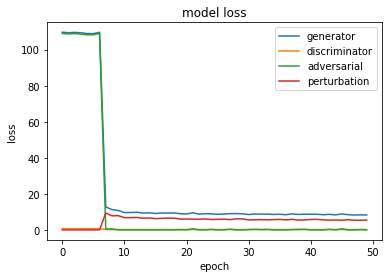

In [ ]:
plt.plot(history.history['g_loss'])
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_adv_loss'])
plt.plot(history.history['g_perturb_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator', 'adversarial', 'perturbation'], loc='best')

plt.show()

Plot the generator's progress through the epochs:


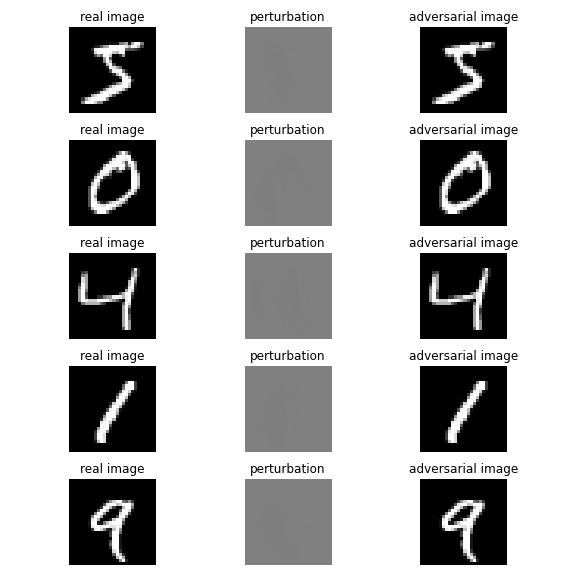

In [ ]:
import tensorflow_docs.vis.embed as embed

image_pattern = f'{IMAGES_DIR}/{BASE_FILENAME}*.png'
gif_path = f'{IMAGES_DIR}/{BASE_FILENAME}.gif'

images_to_gif(image_pattern, gif_path, delete_frames=True)
embed.embed_file(gif_path)

### Classifying generated images using `MNISTConvTarget`

We'll test the generator's performance by classifying the adversarial images it creates for the test set using the `MNISTConvTarget` model.

In [ ]:
adv_images, perturbations = generate_adv_examples(
    generator,
    test_images,
    perturb_bound=PERTURB_BOUND
)

In [ ]:
probs = target.predict(adv_images)

In [ ]:
predictions = probs.argmax(axis=1)

Display and classify adversarial images obtained for a sample of 5 images:

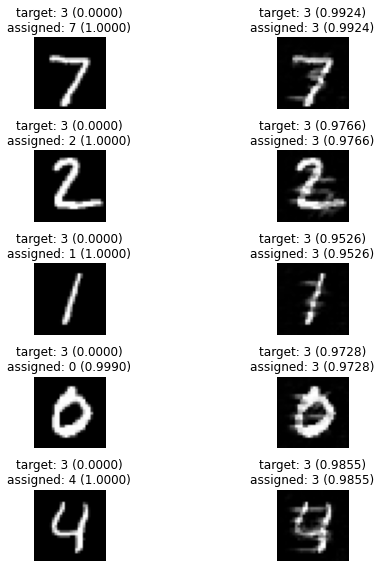

In [ ]:
plot_image_results(
    test_images[:5],
    adv_images[:5],
    target,
    TARGET_LABEL
)

#### Attack success rate

In [ ]:
asr = (predictions == TARGET_LABEL).sum() / len(predictions)

print(f'Attack success rate: {asr * 100:.2f}%')

Attack success rate: 99.08%


#### Average probability of target prediction

In [ ]:
avg_prob = probs[:, TARGET_LABEL].mean()

print(f'Average probability of predicting "{TARGET_LABEL}": {avg_prob:.4f}')

Average probability of predicting "3": 0.9302


#### Average perturbation strength ($L_2$-norm)

In [ ]:
reshaped = tf.reshape(perturbations, (tf.shape(perturbations)[0], -1))
avg_perturb_strength = tf.reduce_mean(tf.norm(reshaped, axis=1)).numpy()

print(f'Average perturbation strength: {avg_perturb_strength:.4f}')

Average perturbation strength: 5.5524


#### Attack confusion matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:194: RuntimeWarning: invalid value encountered in true_divide


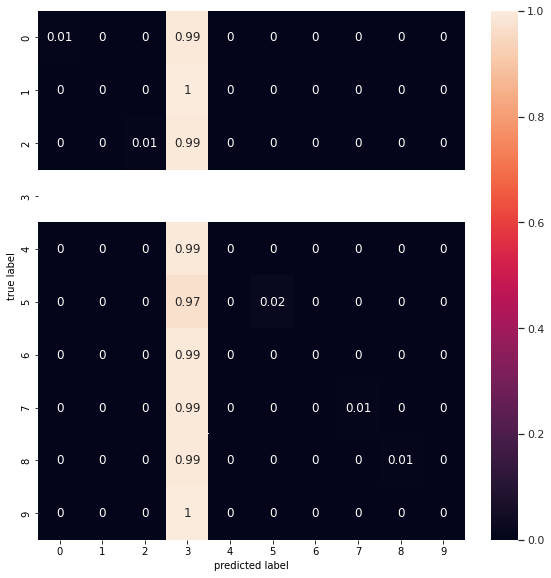

In [ ]:
plot_confusion_matrix(
    test_labels,
    predictions,
    classes=range(10),
    ignore_idx=TARGET_LABEL
)